# Generate examples of noise samples used in vision experiments

In [2]:
# import libraries and functions
import os  # handy system and path functions
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import random, repeat, zeros, linspace, mean, std, meshgrid, real
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift

#from psychopy import gui, core
from PIL import Image


In [3]:
# # Back up load a saved noise image
# image = np.load('../noise_samples/pink_pink_0.npy')

# fig = plt.figure(frameon=False) # show image without axes

# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
# ax.imshow(image, cmap="gray")

# fig.savefig("../noise_samples/pink_noise")

def apply_filter(imLum, imFiltX):
    imLumX  = fftshift(fft2(fftshift(imLum)))
    imProdX = imLumX * imFiltX
    return fftshift(real(ifft2(ifftshift(imProdX))))

In [53]:
expInfo = {'image_height_pix': 500,
           'image_width_pix': 500,
           'noise_type':['white', 'pink'],
           'pixel_scale':1,
           'interactive':[False, True]}

# # Show pop-up for experimenter input
# dlg = gui.DlgFromDict(dictionary=expInfo, sortKeys=False, title="Noise Generator")
# if dlg.OK == False:
#     core.quit()  # user pressed cancel

image_height_pix = expInfo["image_height_pix"]
image_width_pix = expInfo["image_width_pix"]
noise_type = expInfo["noise_type"]
pixel_scale = expInfo["pixel_scale"] # the resolution of the noise
interactive = expInfo["interactive"]

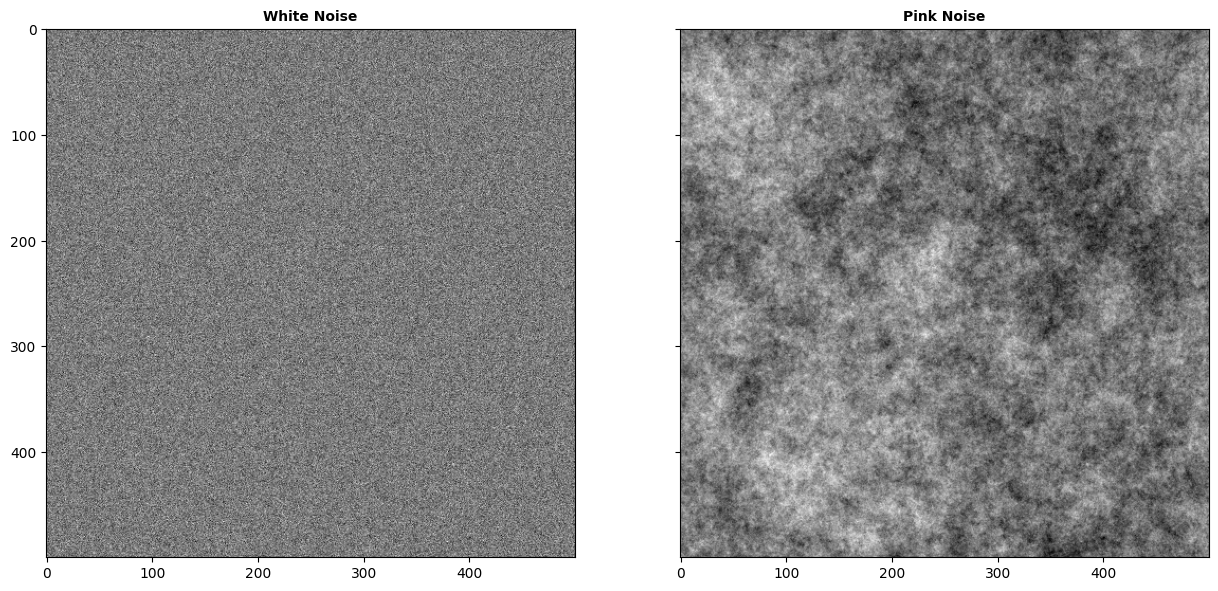

In [54]:
# Step 1) Generate White Noise ====================================================================================================
im_size = int(max(image_height_pix, image_width_pix)) # we can trim the longer axis after but we start with a square noise stimulus # we used to add 1 here I think it has to do with the nyquist frequency
im_noise  = zeros([im_size,im_size])
nyquist_f = im_size/2.0 # The Nyquist Frequency is 1/2 of the sampling rate
# Creating an equally spaced array from -nyquistF to +nyquistF
f_arr = linspace(-nyquist_f,nyquist_f,im_size)

white_noise_original = random.standard_normal((im_size, im_size)) # draw samples from a standard Normal distribution (mean=0, stdev=1).

#plt.imshow(white_noise_original)

# scale by pixelScale
white_noise_scaled = repeat(white_noise_original, pixel_scale, axis=1)
white_noise_scaled = repeat(white_noise_scaled, pixel_scale, axis=0)

# trim noise to be the right size
noise = white_noise_scaled[0:im_size, 0:im_size]

# fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10),sharex=True,sharey=True)
# ax = axes[0]
# ax.set_title("Original Noise", fontsize=10, fontweight='bold')
# ax.imshow(white_noise_original)

# ax = axes[1]
# ax.set_title("Scaled Noise", fontsize=10, fontweight='bold')
# ax.imshow(white_noise_scaled)

# Step 2) Filter the noise for pink noise ===============================================================================
exponent  = 1
[f_x,f_y] = meshgrid(f_arr,f_arr)
f_r       = abs((f_x**2.0 + f_y**2.0)**0.5)
scale     = zeros([im_size,im_size])
denom     = (f_r**exponent)
scale[denom!=0] = 1.0/denom[denom!=0]

pink_noise = apply_filter(white_noise_scaled, scale)
    

# Step 3) Trim the Noise to Desired Size, and 
trimmed_noise = noise[0:image_width_pix, 0:image_height_pix]
trimmed_noise = trimmed_noise - mean(trimmed_noise.flat) # this code normalizes the noise, setting the mean to 0 and standard deviation to 1
trimmed_noise = (trimmed_noise / std(trimmed_noise.flat))

# Step 3) Save and Return the Noise Samples ==========================================================================================
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10),sharex=True,sharey=True)
ax = axes[0]
ax.set_title("White Noise", fontsize=10, fontweight='bold')
ax.imshow(white_noise_scaled, cmap = "gray")

ax = axes[1]
ax.set_title("Pink Noise", fontsize=10, fontweight='bold')
ax.imshow(pink_noise, cmap = "gray")

In [55]:
# Add an alpha channel to the noise images ============================================
# Step 1) Normalize noise between 0 and 1
noise_shifted = white_noise_scaled - np.min(white_noise_scaled)
noise_norm = noise_shifted / (np.max(noise_shifted))
rgb_noise = noise_norm*255

## Step 1.1) Checking that the images look the same 
# fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(15,10),sharex=True,sharey=True)
# ax = axes[0]
# ax.set_title("Original Noise", fontsize=10, fontweight='bold')
# ax.imshow(white_noise_scaled, cmap = "gray")

# ax = axes[1]
# ax.set_title("Shifted Noise", fontsize=10, fontweight='bold')
# ax.imshow(noise_shifted, cmap = "gray")

# ax = axes[2]
# ax.set_title("Normalized Noise", fontsize=10, fontweight='bold')
# ax.imshow(noise_norm, cmap = "gray")

# ax = axes[3]
# ax.set_title("RGB Range Noise", fontsize=10, fontweight='bold')
# ax.imshow(rgb_noise, cmap = "gray")

# Step 2) Change the image to RGB mode
image = Image.fromarray(rgb_noise)
image = image.convert("RGBA")

# add alpha channel
if image.mode == "RGBA":
    a_channel = image.getchannel("R")
    image.putalpha(a_channel)

image.save("white_noise.png")

# Do the same for the pink noise
pink_noise = pink_noise - np.min(pink_noise)
pink_noise = pink_noise / (np.max(pink_noise))
pink_noise = pink_noise*255

pink_image = Image.fromarray(pink_noise)
pink_image = pink_image.convert("RGBA")

# add alpha channel
if pink_image.mode == "RGBA":
    a_channel = pink_image.getchannel("R")
    pink_image.putalpha(a_channel)

pink_image.save("pink_noise.png")